In [1]:
from keras.applications import VGG16
from keras import backend as K
import numpy as np
import matplotlib.pyplot as viz

Using TensorFlow backend.


In [2]:
model = VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [3]:
def postprocess(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x = (x * 0.1 + 0.5) * 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [4]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    # normalize gradients
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    #computation graph
    iterate = K.function([model.input], [loss, grads])
    
    # gray noisy image
    input_image = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # gradient ascent step
    step = 1.
    for i in range(40):
        _, grads_value = iterate([input_image])
        input_image += grads_value * step
    
    return postprocess(input_image[0])

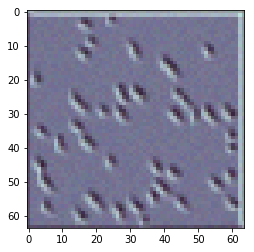

In [5]:
result = generate_pattern('block1_conv1', 4, 64)
viz.imshow(result)

In [6]:
# displays first 64 filter patterns of a layer in 8x8 grid
grid_size = 8

def get_filter_patterns(layer_name):
    pattern_size = 64
    margin = 3
    result_size = grid_size * pattern_size + (grid_size - 1) * margin
    
    result = np.zeros((result_size, result_size, 3), dtype=np.uint8)
    
    for i in range(grid_size):
        for j in range(grid_size):
            x_start = i * (pattern_size + margin)
            x_end = x_start + pattern_size
            y_start = j * (pattern_size + margin)
            y_end = y_start + pattern_size
            result[x_start:x_end, y_start:y_end, :] = generate_pattern(layer_name, i * 8 + j, pattern_size)
    return result

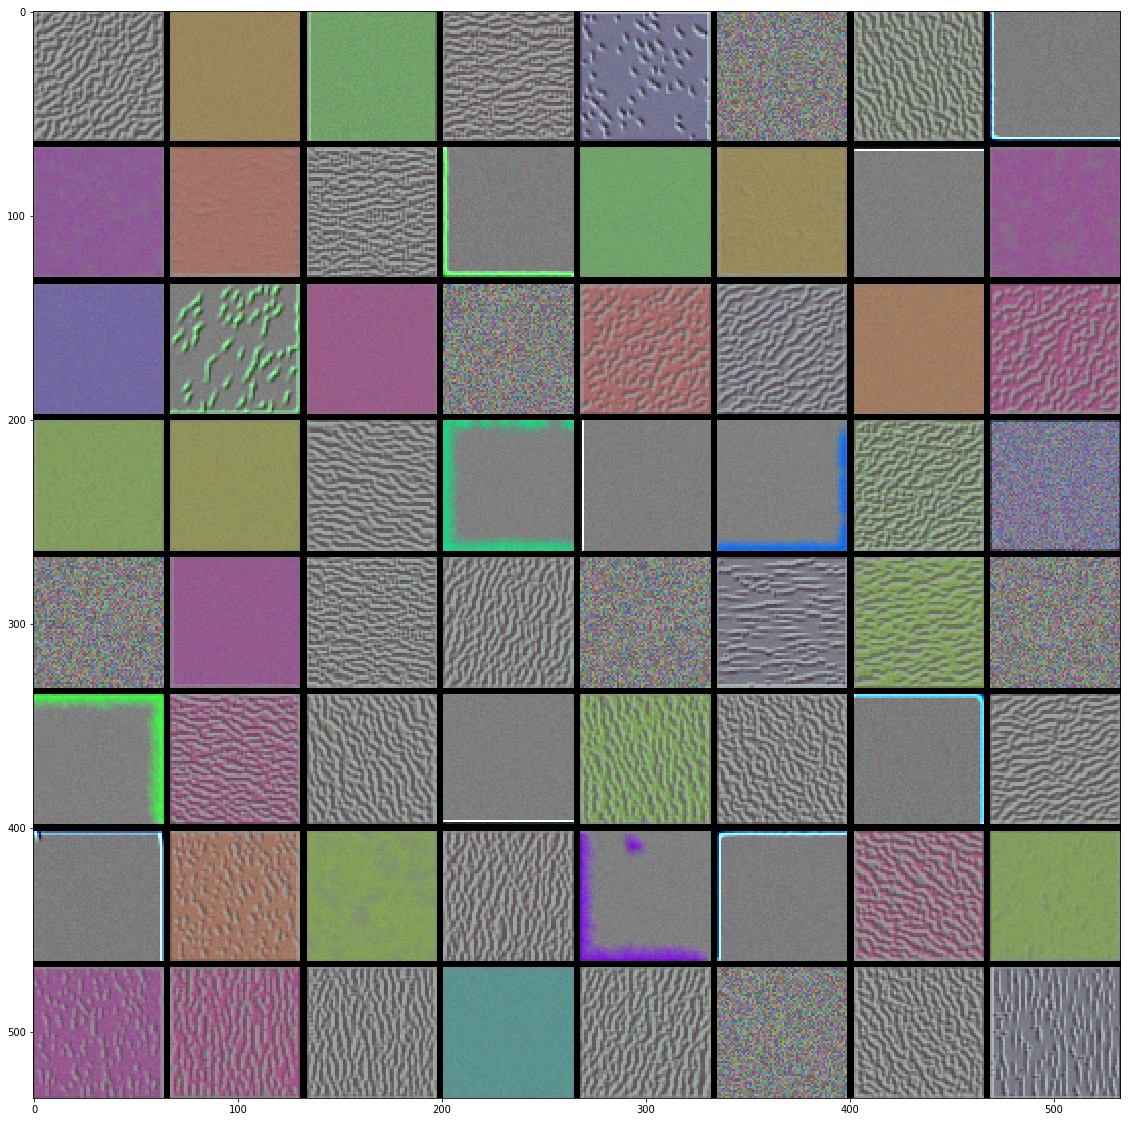

In [7]:
viz.figure(figsize=(20, 20))
viz.imshow(get_filter_patterns('block1_conv1'))

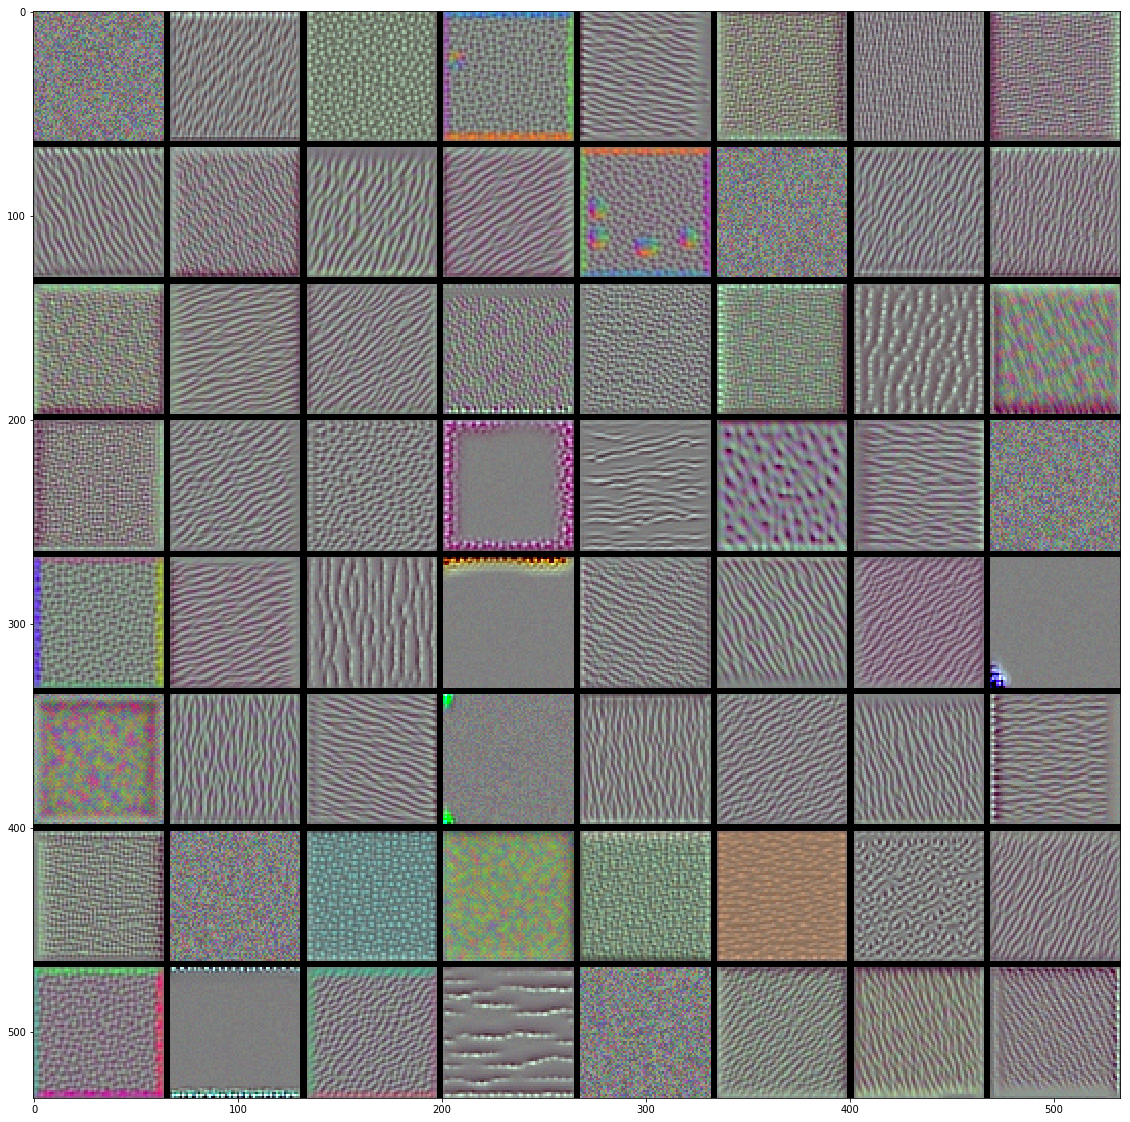

In [8]:
viz.figure(figsize=(20, 20))
viz.imshow(get_filter_patterns('block2_conv1'))

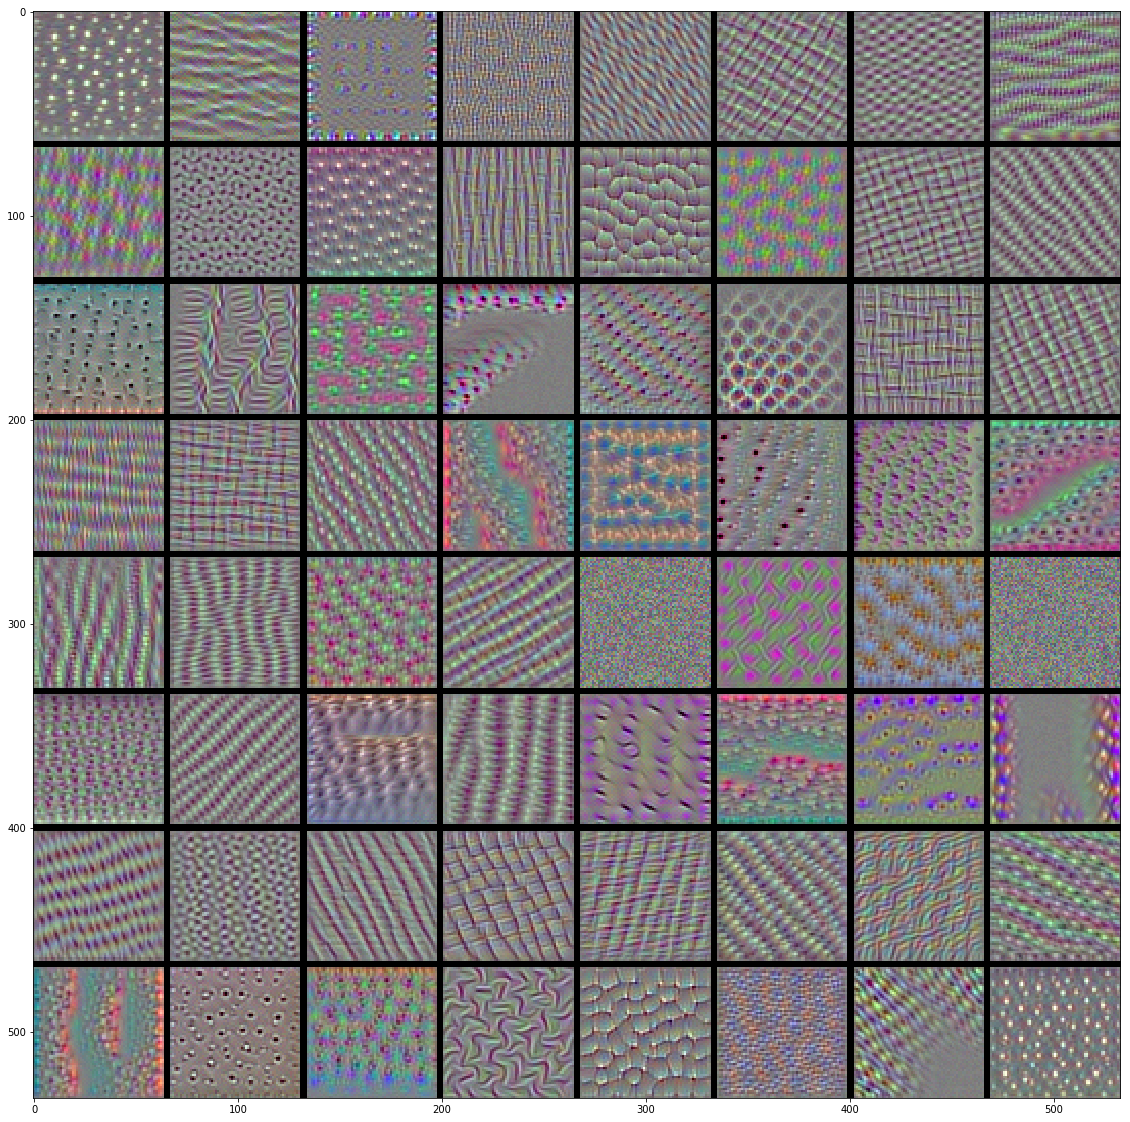

In [9]:
viz.figure(figsize=(20, 20))
viz.imshow(get_filter_patterns('block3_conv1'))

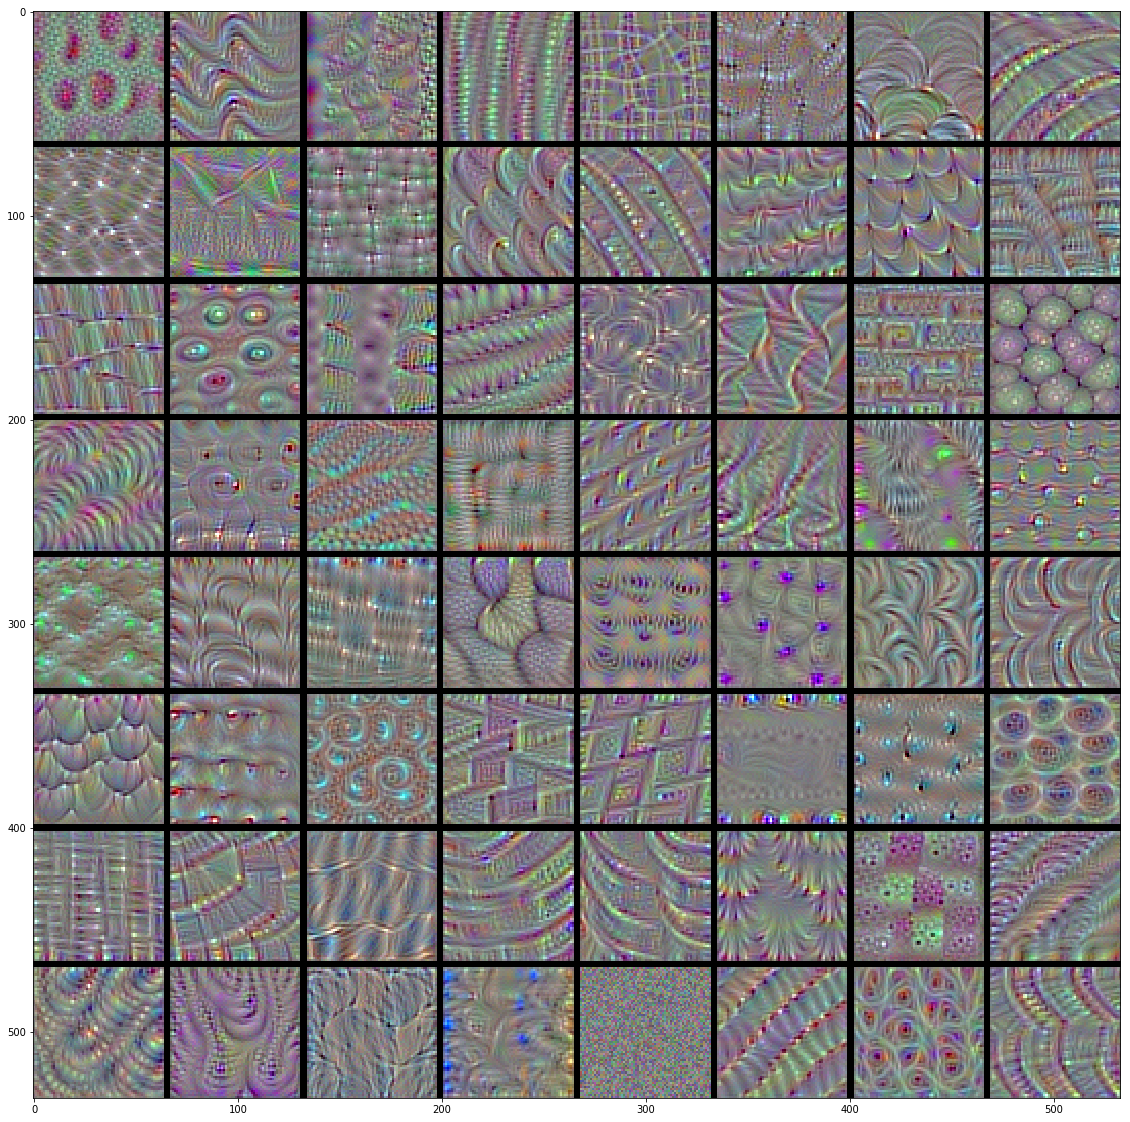

In [10]:
viz.figure(figsize=(20, 20))
viz.imshow(get_filter_patterns('block4_conv1'))